# Install and import dependencies

In [1]:
!pip install -U tensorflow_datasets

     ---------------------------------------- 5.4/5.4 MB 5.9 MB/s eta 0:00:00
     -------------------------------------- 135.8/135.8 kB 8.4 MB/s eta 0:00:00
     ---------------------------------------- 101.3/101.3 kB ? eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 227.6/227.6 kB 6.8 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21548 sha256=8b7b0062937b69bd3676bbf323e6596df3a45c6b88abeae4111be7e2f83d82ce
  Stored in directory: c:\users\youcode\appdata\local\pip\cache\wheels\76\40\54\417a4d64a01b61b247658d83597e1dc83c3de01fc0cef44972
Successfully built promise


In [2]:
import tensorflow as tf

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Import the Fashion MNIST dataset

In [5]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to C:\Users\Youcode\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [6]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Explore the data

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


# Preprocess the data

The value of each pixel in the image data is an integer in the range [0,255]. For the model to work properly, these values need to be normalized to the range [0,1]. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [8]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

# Explore the processed data

Let's plot an image to see what it looks like

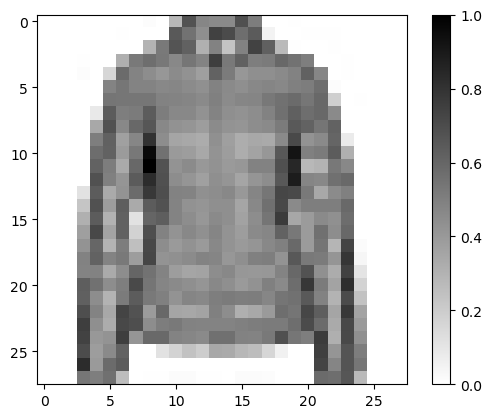

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

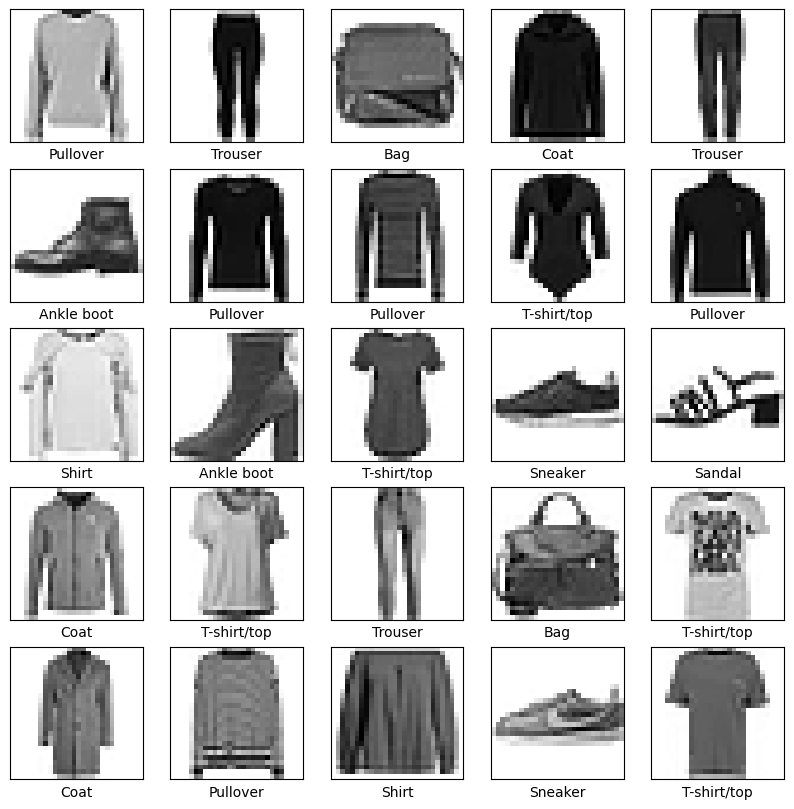

In [10]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

# Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the layer. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like tf.keras.layers.Dense, have internal parameters which are adjusted ("learned") during training.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model

First, we define the iteration behavior for the train dataset:

- Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we perform training).
- The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples.
- And dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the model.fit method:

- Feed the training data to the model using train_dataset.
- The model learns to associate images and labels.
- The epochs=5 parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [14]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [15]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 9s 3ms/step - loss: 0.4933 - accuracy: 0.8263
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3738 - accuracy: 0.8659
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3314 - accuracy: 0.8782
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3123 - accuracy: 0.8855
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2929 - accuracy: 0.8932


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.89 (or 89%) on the training data.

# Evaluate accuracy

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3492 - accuracy: 0.8769
Accuracy on test dataset: 0.8769000172615051


# Make predictions and explore

In [17]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 132ms/step


In [18]:
predictions.shape

(32, 10)

In [19]:
predictions[0]

array([1.6606622e-05, 5.8352459e-08, 1.1932461e-02, 2.3919512e-07,
       9.3158585e-01, 2.0977563e-11, 5.6459934e-02, 2.6900504e-11,
       4.7415115e-06, 8.2045581e-10], dtype=float32)

In [20]:
np.argmax(predictions[0])

4

In [21]:
test_labels[0]

4

In [22]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array.

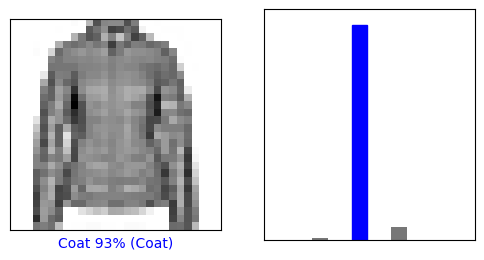

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

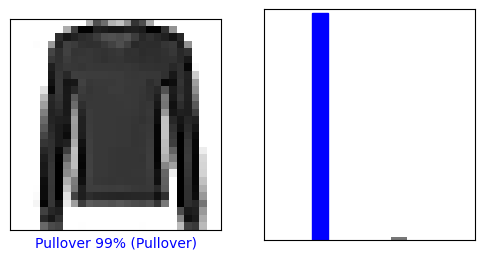

In [24]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

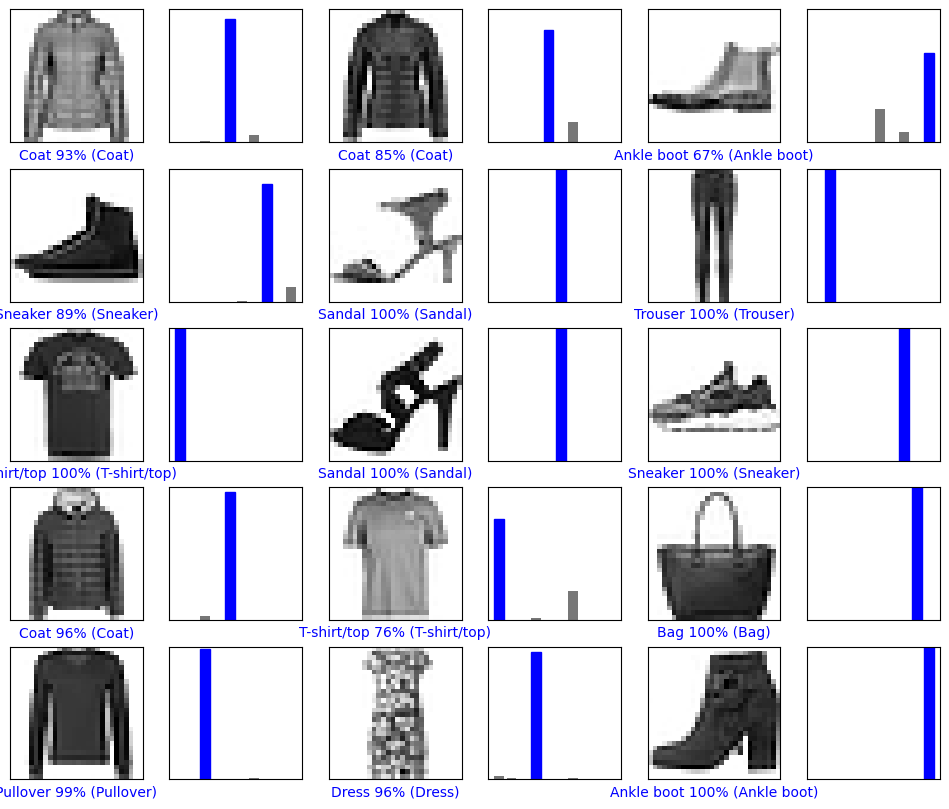

In [25]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image.

In [29]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [27]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [28]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 61ms/step
[[1.6606622e-05 5.8352345e-08 1.1932461e-02 2.3919486e-07 9.3158585e-01
  2.0977563e-11 5.6459934e-02 2.6900452e-11 4.7415115e-06 8.2045426e-10]]


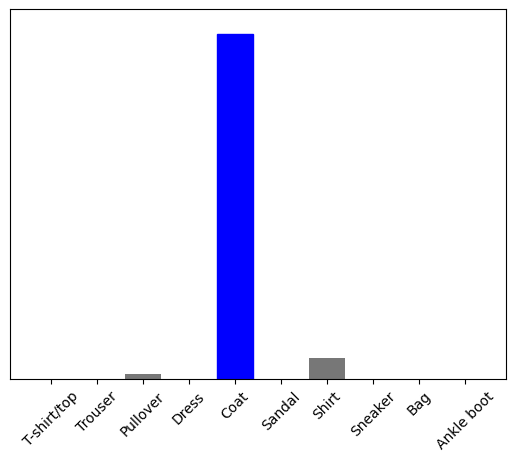

In [30]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [31]:
np.argmax(predictions_single[0])

4